# Heuristic

This heuristic starts with solving the TSP on the circles centers.
Then the optimal hitting points for the corresponding order are computed.
These points are repeatedly used as new centers for the TSP optimization.

In [11]:
import typing

class Circle:
    """
    Instance representation
    """
    def __init__(self, x: float, y: float, radius: float):
        self.x = x
        self.y = y
        self.radius = radius

    def __repr__(self):
        return f"Circle({self.x}, {self.y}, r={self.radius})"

    def __eq__(self, other):
        return self.x == other.x and  self.y == other.y and self.radius == other.radius

    def __hash__(self):
        return hash((self.x, self.y ,self.radius))

# simple plotting  helper
import matplotlib.pyplot as plt
def plot_circle(ax: plt.Axes, circle: Circle, **kwargs):
    patch = plt.Circle((circle.x, circle.y), radius=circle.radius, **kwargs)
    ax.add_patch(patch)

In [12]:
import gurobipy as gp  # requires gurobi to be installed via conda.
from gurobipy import GRB




def compute_hitting_points(circle_sequence: typing.List[Circle], path: bool=False) -> typing.Dict[Circle, typing.Tuple[float ,float]]:
    """
    This function efficiently computes the optimal CE-Tour for a given sequence(!) of circles.
    If the order of circles is given, the problem becomes an easy to solve SOC-Program.
    The tour may implicitly cross circles earlier.

    Learn more about SOC: https://www.gurobi.com/events/gurobi-qcp-and-socp-optimizer-overview/
    :param circle_sequence: Sequence of circles (the exact order they are visited)
    :param path: Compute a path instead of a tour.
    :return: Sequence of coordinates of the tour. The coordinates may be slightly off (but not critical).
    """
    model = gp.Model()

    # tour points
    x = model.addVars(circle_sequence, lb=-GRB.INFINITY, ub=GRB.INFINITY, vtype=GRB.CONTINUOUS)
    y = model.addVars(circle_sequence, lb=-GRB.INFINITY, ub=GRB.INFINITY, vtype=GRB.CONTINUOUS)

    # length of segments
    f = model.addVars(circle_sequence, lb=0.0, ub=GRB.INFINITY, vtype=GRB.CONTINUOUS)
    model.setObjective(gp.quicksum(f.values()), sense=GRB.MINIMIZE)

    # x and y-length of segments (difference of segment points)
    w = model.addVars(circle_sequence, lb=-GRB.INFINITY, ub=GRB.INFINITY, vtype=GRB.CONTINUOUS)
    u = model.addVars(circle_sequence, lb=-GRB.INFINITY, ub=GRB.INFINITY, vtype=GRB.CONTINUOUS)

    # difference of tour points to circle center
    s = model.addVars(circle_sequence, lb=-GRB.INFINITY, ub=GRB.INFINITY, vtype=GRB.CONTINUOUS)
    t = model.addVars(circle_sequence, lb=-GRB.INFINITY, ub=GRB.INFINITY, vtype=GRB.CONTINUOUS)

    # SOC
    for c in circle_sequence:
        model.addQConstr(f[c]*f[c] >= w[c]*w[c] + u[c]*u[c])
        # tour points are within circle radius
        model.addQConstr(s[c]*s[c] + t[c]*t[c] <= c.radius*c.radius)

        # enforce s,t represent difference to circle center
        model.addConstr(s[c] == c.x - x[c])
        model.addConstr(t[c] == c.y - y[c])

    for i, c in enumerate(circle_sequence):
        if path and i==0:
            # for paths, the distance between the endpoints
            # is free
            model.addConstr(w[c]==0)
            model.addConstr(u[c]==0)
        else:
            # enforce w,u represent segment lengths (x and y axes)
            prev_c = circle_sequence[(i-1)%len(circle_sequence)]
            model.addConstr(w[c] == x[prev_c] - x[c])
            model.addConstr(u[c] == y[prev_c] - y[c])

    model.optimize()
    return {c: (x[c].X, y[c].X) for c in circle_sequence}

In [13]:
from concorde.tsp import TSPSolver
import typing
def compute_tour(points: typing.List[typing.Tuple[float, float]]) -> typing.List[int]:
    solver = TSPSolver.from_data([x*1000 for x,y in points], [y*1000 for x,y in points], norm="EUC_2D")
    solution = solver.solve(verbose=False)
    return [int(i) for i in solution.tour]

def find_good_tour(circles: typing.List[Circle], iterations=10) -> typing.List[int]:
    tour = [i for i in range(len(circles))]
    hitting_points = {c: (c.x, c.y) for c in circles}
    for _ in range(iterations):
        tour = compute_tour([hitting_points[c] for c in circles])
        hitting_points = compute_hitting_points([circles[i] for i in tour])
    return tour


In [14]:
circles = [
    Circle(1.5*x, 1.5*y, 1) for x in range(7) for y in range(7)
]

Problem Name: 92e6d3ef842b43019be1a5ae8e5cc5ae
Problem Type: TSP
Number of Nodes: 49
Rounded Euclidean Norm (CC_EUCLIDEAN)
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)
CCtsp_solve_dat ...

Finding a good tour for compression ...
linkern ...
Starting Cycle: 76243
   0 Steps   Best: 74121   0.00 seconds
  24 Total Steps.
Best cycle length: 74121
Lin-Kernighan Running Time: 0.00
LK Initial Run: 74121.0
LK Run 0: 74121.0
LK Run from best tour: 74121.0
Time to find compression tour: 0.02 (seconds)
Set initial upperbound to 74121 (from tour)
  LP Value  1: 74121.000000  (0.00 seconds)
New lower bound: 74121.000000
Exact lower bound: 74121.000000
DIFF: 0.000000
Established Bound: 74121
Optimal tour: 74121
Total Time to solve TSP: 0.03
CPU model: AMD Ryzen 7 5700X 8-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads

Optimize a model with 196 rows, 343 columns and 490 nonzeros
Model fingerprint: 0xf2c14ee6

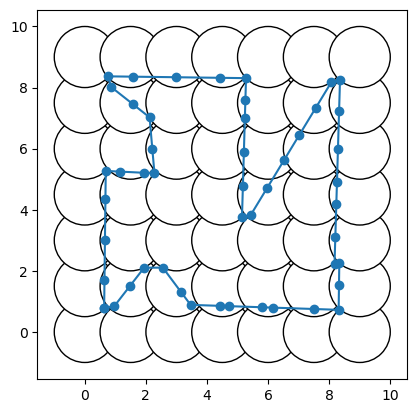

In [15]:
fig = plt.Figure(figsize=(15,15))
ax = plt.gca()
tour = find_good_tour(circles, 1)
hitting_points = compute_hitting_points([circles[i] for i in tour])
tour = [hitting_points[circles[i]] for i in tour]
for c in circles:
    plot_circle(ax, c, facecolor="white", zorder=1, ec="black")
plt.plot([p[0] for p in tour]+[tour[0][0]], [p[1] for p in tour]+[tour[0][1]], 'o-')
ax.set_aspect('equal', 'box')
plt.show()

In [16]:
from cetsp_bnb2.heuristics import AdaptiveTspHeuristic

In [17]:
import random

# get random coordinates
circles = [
    Circle(20 * random.random(), 20 * random.random(), random.uniform(0.5,2.0)) for _ in range(100)
]


Problem Name: 1803e6bc5882404b9edf04604588fdaf
Problem Type: TSP
Number of Nodes: 100
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 185505
   0 Steps   Best: 159957   0.00 seconds
  50 Total Steps.
Best cycle length: 159957
Lin-Kernighan Running Time: 0.01
LK Initial Run: 159957.0
LK Run 0: 159957.0
LK Run from best tour: 159957.0
Time to find compression tour: 0.04 (seconds)
Set initial upperbound to 159957 (from tour)
  LP Value  1: 153772.000000  (0.00 seconds)
  LP Value  2: 158285.500000  (0.02 seconds)
  LP Value  3: 159152.000000  (0.03 seconds)
  LP Value  4: 159771.250000  (0.05 seconds)
  LP Value  5: 159890.500000  (0.07 seconds)
  LP Value  6: 159957.000000  (0.08 seconds)
New lower bound: 159957.000000
Exact lower bound: 159957.000000
DIFF: 0.000000
Established Bound: 159957
Optimal tour: 159957
Total Time to solve TSP: 0.14
Problem Name: 3a11cdeae121477892cd7197d0f13fe8
Problem Type: TSP
Numbe

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


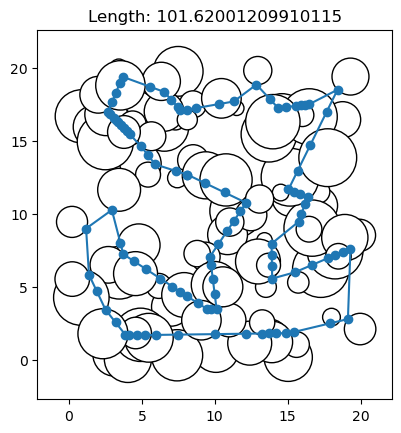

Problem Name: b1f676ff695a4df4b09139cb57f0ec33
Problem Type: TSP
Number of Nodes: 100
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 128321
   0 Steps   Best: 113176   0.00 seconds
   1 Steps   Best: 111461   0.00 seconds
   3 Steps   Best: 110701   0.00 seconds
  50 Total Steps.
Best cycle length: 110701
Lin-Kernighan Running Time: 0.00
LK Initial Run: 110701.0
LK Run 0: 110701.0
LK Run from best tour: 110701.0
Time to find compression tour: 0.01 (seconds)
Set initial upperbound to 110701 (from tour)
  LP Value  1: 110701.000000  (0.00 seconds)
New lower bound: 110701.000000
Exact lower bound: 110701.000000
DIFF: 0.000000
Established Bound: 110701
Optimal tour: 110701
Total Time to solve TSP: 0.01
Problem Name: 516bfa2c50fe41629555a90e711efcd6
Problem Type: TSP
Number of Nodes: 100
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 1

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


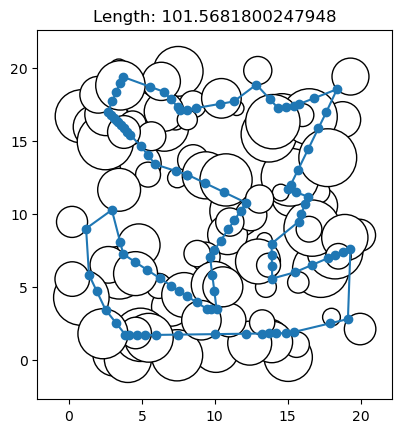

Problem Name: f3ea9823677849f3aaec4da1c2fd0313
Problem Type: TSP
Number of Nodes: 100
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 131985
   0 Steps   Best: 109494   0.00 seconds
  50 Total Steps.
Best cycle length: 109494
Lin-Kernighan Running Time: 0.00
LK Initial Run: 109494.0
LK Run 0: 109494.0
LK Run from best tour: 109494.0
Time to find compression tour: 0.01 (seconds)
Set initial upperbound to 109494 (from tour)
  LP Value  1: 109087.500000  (0.00 seconds)
  LP Value  2: 109494.000000  (0.00 seconds)
New lower bound: 109494.000000
Exact lower bound: 109494.000000
DIFF: 0.000000
Established Bound: 109494
Optimal tour: 109494
Total Time to solve TSP: 0.01
Problem Name: 1b632489018145d5b2105b6417d3cf9c
Problem Type: TSP
Number of Nodes: 100
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 121299
   0 Steps   Best: 101967   0.0

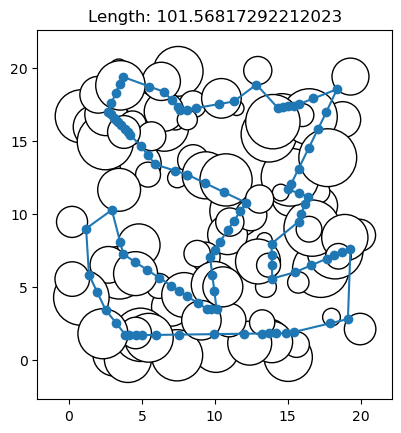

Problem Name: 0770dbb7fdb14a1aa04a74b85af54e7d
Problem Type: TSP
Number of Nodes: 100
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 144387
   0 Steps   Best: 115251   0.00 seconds
   2 Steps   Best: 115225   0.00 seconds
  50 Total Steps.
Best cycle length: 115225
Lin-Kernighan Running Time: 0.00
LK Initial Run: 115225.0
LK Run 0: 115225.0
LK Run from best tour: 115225.0
Time to find compression tour: 0.01 (seconds)
Set initial upperbound to 115225 (from tour)
  LP Value  1: 114462.000000  (0.00 seconds)
  LP Value  2: 115225.000000  (0.00 seconds)
New lower bound: 115225.000000
Exact lower bound: 115225.000000
DIFF: 0.000000
Established Bound: 115225
Optimal tour: 115225
Total Time to solve TSP: 0.02
Problem Name: 446ebca66d9f433baa7f7cf12f9437be
Problem Type: TSP
Number of Nodes: 100
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycl

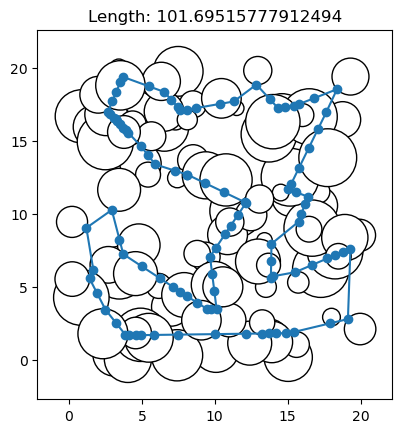

Problem Name: 4d9619a65f9f4c1ead0eefe653d855cf
Problem Type: TSP
Number of Nodes: 100
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 148374
   0 Steps   Best: 108129   0.00 seconds
   1 Steps   Best: 107858   0.00 seconds
   5 Steps   Best: 107784   0.00 seconds
  50 Total Steps.
Best cycle length: 107784
Lin-Kernighan Running Time: 0.00
LK Initial Run: 107784.0
LK Run 0: 107784.0
LK Run from best tour: 107784.0
Time to find compression tour: 0.01 (seconds)
Set initial upperbound to 107784 (from tour)
  LP Value  1: 107784.000000  (0.00 seconds)
New lower bound: 107784.000000
Exact lower bound: 107784.000000
DIFF: 0.000000
Established Bound: 107784
Optimal tour: 107784
Total Time to solve TSP: 0.01
Gurobi Optimizer version 10.0.1 build v10.0.1rc0 (linux64)

CPU model: AMD Ryzen 7 5700X 8-Core Processor, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 16 logical processors, using up to 16 thre

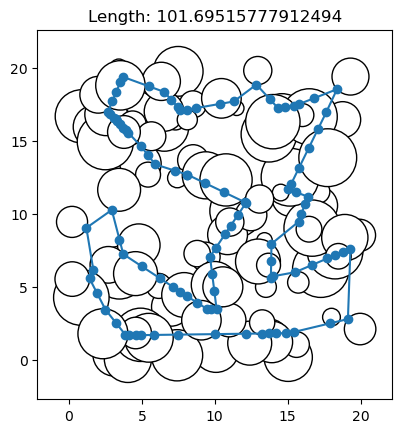

Problem Name: dfddea2b61da452a854119c40c48d9b5
Problem Type: TSP
Number of Nodes: 100
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 158986
   0 Steps   Best: 119404   0.00 seconds
   1 Steps   Best: 119114   0.00 seconds
  50 Total Steps.
Best cycle length: 119114
Lin-Kernighan Running Time: 0.00
LK Initial Run: 119114.0
LK Run 0: 119114.0
LK Run from best tour: 119114.0
Time to find compression tour: 0.01 (seconds)
Set initial upperbound to 119114 (from tour)
  LP Value  1: 117805.000000  (0.00 seconds)
  LP Value  2: 119114.000000  (0.00 seconds)
New lower bound: 119114.000000
Exact lower bound: 119114.000000
DIFF: 0.000000
Established Bound: 119114
Optimal tour: 119114
Total Time to solve TSP: 0.02
Problem Name: 270a7f45a077463abdbaae1cceec0de3
Problem Type: TSP
Number of Nodes: 100
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycl

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


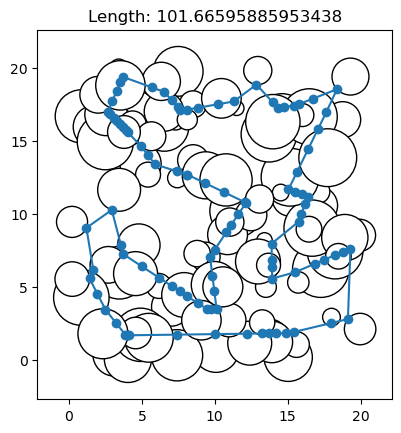

Problem Name: a2f1467cd6cd44dab59d2a81bf5c1ffd
Problem Type: TSP
Number of Nodes: 100
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 148760
   0 Steps   Best: 108318   0.00 seconds
  50 Total Steps.
Best cycle length: 108318
Lin-Kernighan Running Time: 0.00
LK Initial Run: 108318.0
LK Run 0: 108318.0
LK Run from best tour: 108318.0
Time to find compression tour: 0.01 (seconds)
Set initial upperbound to 108318 (from tour)
Basic dual change required, but no candidate edges
  LP Value  1: 107301.000000  (0.00 seconds)
  LP Value  2: 107912.500000  (0.00 seconds)
  LP Value  3: 108318.000000  (0.00 seconds)
New lower bound: 108318.000000
Exact lower bound: 108318.000000
DIFF: 0.000000
Established Bound: 108318
Optimal tour: 108318
Total Time to solve TSP: 0.01
Problem Name: 0ac94b4efa184eadb25ff8254af6bc48
Problem Type: TSP
Number of Nodes: 100
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a 

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway
ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


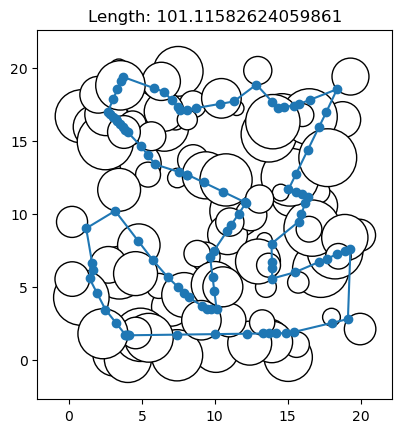

Problem Name: cc958bf68f744644ade168d933bf3b5a
Problem Type: TSP
Number of Nodes: 100
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 129410
   0 Steps   Best: 107467   0.00 seconds
  50 Total Steps.
Best cycle length: 107467
Lin-Kernighan Running Time: 0.00
LK Initial Run: 107467.0
LK Run 0: 107467.0
LK Run from best tour: 107467.0
Time to find compression tour: 0.01 (seconds)
Set initial upperbound to 107467 (from tour)
  LP Value  1: 106108.500000  (0.00 seconds)
  LP Value  2: 107467.000000  (0.00 seconds)
New lower bound: 107467.000000
Exact lower bound: 107467.000000
DIFF: 0.000000
Established Bound: 107467
Optimal tour: 107467
Total Time to solve TSP: 0.01
Problem Name: b72b9bcbcf1d46f69a8b8dd0598293ac
Problem Type: TSP
Number of Nodes: 100
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 120997
   0 Steps   Best: 101116   0.0

ERROR: No dual change in basis finding code
Did not find a basic optimal solution
Fractional matching routine failed
No warmstart, stumbling on anyway


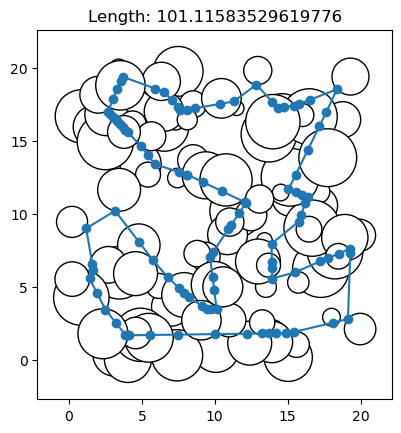

Problem Name: 895148974a8b440988df11face477bb5
Problem Type: TSP
Number of Nodes: 100
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 111796
   0 Steps   Best: 109810   0.00 seconds
  50 Total Steps.
Best cycle length: 109810
Lin-Kernighan Running Time: 0.00
LK Initial Run: 109810.0
LK Run 0: 109810.0
LK Run from best tour: 109810.0
Time to find compression tour: 0.01 (seconds)
Set initial upperbound to 109810 (from tour)
  LP Value  1: 108503.000000  (0.00 seconds)
  LP Value  2: 109810.000000  (0.00 seconds)
New lower bound: 109810.000000
Exact lower bound: 109810.000000
DIFF: 0.000000
Established Bound: 109810
Optimal tour: 109810
Total Time to solve TSP: 0.01
Problem Name: 24effafe35f445868a7837572e7f69f9
Problem Type: TSP
Number of Nodes: 100
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 101017
   0 Steps   Best: 100141   0.0

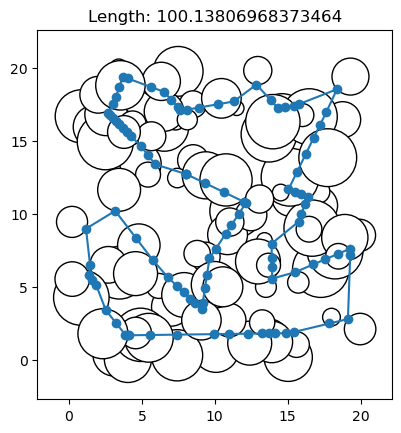

Problem Name: 84fafede93864ea2afbbca3e12bae623
Problem Type: TSP
Number of Nodes: 100
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 157690
   0 Steps   Best: 115157   0.00 seconds
  50 Total Steps.
Best cycle length: 115157
Lin-Kernighan Running Time: 0.00
LK Initial Run: 115157.0
LK Run 0: 115157.0
LK Run from best tour: 115157.0
Time to find compression tour: 0.01 (seconds)
Set initial upperbound to 115157 (from tour)
  LP Value  1: 113611.000000  (0.00 seconds)
  LP Value  2: 115087.800000  (0.01 seconds)
  LP Value  3: 115157.000000  (0.01 seconds)
New lower bound: 115157.000000
Exact lower bound: 115157.000000
DIFF: 0.000000
Established Bound: 115157
Optimal tour: 115157
Total Time to solve TSP: 0.02
Problem Name: c52081eebede4c95964a4fb7c5c1f51e
Problem Type: TSP
Number of Nodes: 100
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting 

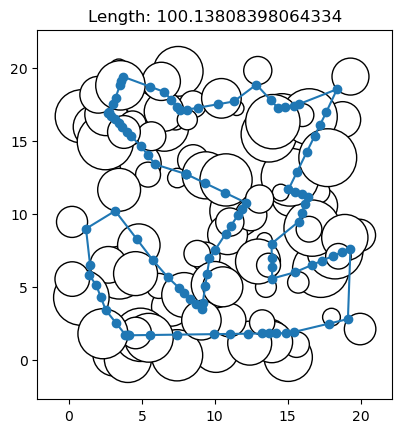

In [18]:

heuristic = AdaptiveTspHeuristic([c.x for c in circles], [c.y for c in circles], [c.radius for c in circles])
for i in range(10):
    heuristic.optimize(10)
    fig = plt.Figure(figsize=(15,15))
    ax = plt.gca()
    tour = heuristic.tour
    hitting_points = compute_hitting_points([circles[i] for i in tour])
    tour = [hitting_points[circles[i]] for i in tour]
    for c in circles:
        plot_circle(ax, c, facecolor="white", zorder=1, ec="black")
    plt.plot([p[0] for p in tour]+[tour[0][0]], [p[1] for p in tour]+[tour[0][1]], 'o-')
    plt.title(f"Length: {heuristic.length}")
    ax.set_aspect('equal', 'box')
    plt.show()
    heuristic.randomize_hitting_points(0.1)


In [19]:
from cetsp_bnb2.core import optimize, Instance, Circle as Circle_, Point

In [20]:
instance = Instance([Circle_(Point(c.x, c.y), c.radius) for c in circles])
solution = optimize(instance, timelimit=90)

Removed implicit circle (3.20995, 16.1564)
Removed implicit circle (9.43003, 2.89261)
Removed implicit circle (9.08175, 2.72004)
Removed implicit circle (2.54395, 16.8372)
Removed implicit circle (6.53414, 15.9904)
Removed implicit circle (3.52746, 18.828)
Removed implicit circle (4.91446, 1.71981)
Removed implicit circle (18.2477, 7.4639)
Removed implicit circle (16.4813, 16.6784)
Removed implicit circle (16.6715, 9.03645)
Removed implicit circle (15.1619, 12.5293)
Problem Name: 9de4a01ebe73416babb0635b6b543a2e
Problem Type: TSP
Number of Nodes: 89
Rounded Euclidean Norm (CC_EUCLIDEAN)
CCtsp_solve_dat ...
Finding a good tour for compression ...
linkern ...
Starting Cycle: 178772
   0 Steps   Best: 155144   0.00 seconds
  44 Total Steps.
Best cycle length: 155144
Lin-Kernighan Running Time: 0.00
LK Initial Run: 155144.0
LK Run 0: 155144.0
LK Run from best tour: 155144.0
Time to find compression tour: 0.02 (seconds)
Set initial upperbound to 155144 (from tour)
  LP Value  1: 151071.0000